1.1582899543018927
[[0.21626198 0.19952915 0.13844499 0.16207704 0.12514309 0.15854375]
 [0.21624413 0.19955123 0.1384432  0.16209043 0.12511554 0.15855546]
 [0.21632456 0.1996038  0.13843166 0.16186885 0.1251572  0.15861393]
 ...
 [0.21781625 0.19810486 0.13908935 0.16153086 0.12340743 0.16005125]
 [0.21771803 0.19810827 0.13914271 0.16159336 0.1233637  0.16007392]
 [0.21767054 0.19812238 0.13915234 0.16159502 0.12337335 0.16008637]]


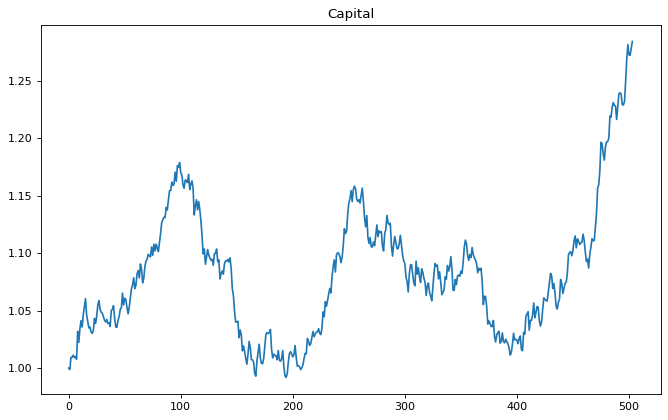

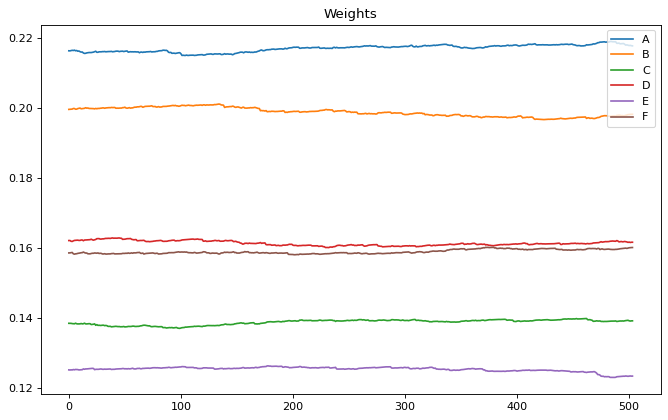

In [24]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.spatial.distance import squareform

k = -1
counter = 0
window = 252*18

df = pd.read_csv('Case 2 Data 2024.csv', index_col = 0)
TRAIN, TEST = train_test_split(df, test_size = 0.2, shuffle = False)

class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''

        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()

        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data

    def hrp_optimization(self, cov_matrix, num_clust, returns_df):
        corr_matrix = cov_matrix.corr()
        dist_matrix = np.sqrt(0.5 * (1 - corr_matrix))
        cond_dist_matrix = squareform(dist_matrix)
        linkage_matrix = sp.cluster.hierarchy.linkage(cond_dist_matrix, 'centroid')
        cluster_assignments = sp.cluster.hierarchy.fcluster(linkage_matrix, num_clust, criterion='inconsistent')
        ivp = 1 / np.diag(cov_matrix)
        ivp /= ivp.sum()

        hrp_weights = pd.Series(index=cov_matrix.columns, dtype=np.float64)
        for id in np.unique(cluster_assignments):
            indices = np.where(cluster_assignments == id)[0]
            covariance = cov_matrix.iloc[indices, indices]
            ivp_cluster = ivp[indices]
            weight = ivp_cluster / np.sum(ivp_cluster)
            hrp_weights[covariance.index] = weight
        hrp_weights /= hrp_weights.sum()

        portfolio_returns = (hrp_weights * returns_df.mean()).sum()
        portfolio_volatility = np.sqrt(np.dot(hrp_weights.T, np.dot(cov_matrix, hrp_weights)))
        portfolio_sharpe = portfolio_returns / portfolio_volatility

        return hrp_weights, portfolio_sharpe, portfolio_returns

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        global df, daily_ret, k, counter, window
        self.running_price_paths = pd.concat([self.running_price_paths.iloc[-window:, :], pd.Series(asset_prices, index=self.running_price_paths.columns).to_frame().T], axis=0)
        daily_ret = self.running_price_paths.pct_change().dropna()
        cov_matrix = daily_ret.cov()

        if k == -1:
            k_values = range(1,6)
            best_sharpe_ratio = -np.inf
            best_k = None
            best_weights = None
            for k in k_values:
                hrp_weights, portfolio_sharpe_ratio, portfolio_returns = self.hrp_optimization(cov_matrix, k, daily_ret)
                if portfolio_sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = portfolio_sharpe_ratio
                    best_k = k
            k = best_k
        weights, _, _ = self.hrp_optimization(cov_matrix, k, daily_ret)

        #print(counter)
        counter += 1
        return weights


def grading(train_data, test_data):
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")

    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]

    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0

    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print(sharpe * np.sqrt(252))
print(weights)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()